<h1>Tracking cells over time in 2D and 3D </h1>

First we will load a time series of 2D frames with and will run some typical methods like connected components KNN, GMM 

After that we will play around with the inputs of the frames and use combinations of the peak broadening (Fwhm) and KAM.

After that lets try and get more features with optical flows, some neural networks, to extract more features,...

In [1]:
%matplotlib ipympl

import matplotlib.patheffects as path_effects
import numpy as np
import matplotlib.pyplot as plt
from connected_componets import *   
from load_data import *
from matplotlib.animation import FuncAnimation, FFMpegWriter

In [2]:

#path = r'C:\Users\JohannHaack\source\DTU\MasterThesis\PMP\Data'
path = r'C:\Users\JohannHaack\source\DTU\MasterThesis\Dislocation_Analysis\Data_Small_Steps'

#Load the data
img_size = [1790,1847]
#img_size = [1829,1569]
Img_phi_array, Img_chi_array,Img_phi_array_cropped,Img_chi_array_cropped,order= load_3D_data(path,img_size, 'COM')
print(order)
#The second picture srews up the distribution of the histogram, so i will delete it from the numpy 3D array
#Img_phi_array = np.delete(Img_phi_array, 1, axis=0)
#Img_chi_array = np.delete(Img_chi_array, 1, axis=0)
#Img_phi_array_cropped = np.delete(Img_phi_array_cropped, 1, axis=0)
#Img_chi_array_cropped = np.delete(Img_chi_array_cropped, 1, axis=0)

Skipping Img_chi at index 0 due to insufficient size: (2048, 2048)
Skipping Img_phi at index 0 due to insufficient size: (2048, 2048)
Skipping Img_chi at index 1 due to insufficient size: (2048, 2048)
Skipping Img_phi at index 1 due to insufficient size: (2048, 2048)
Skipping Img_chi at index 2 due to insufficient size: (2048, 2048)
Skipping Img_phi at index 2 due to insufficient size: (2048, 2048)
['63_chi_COM.edf', '64_chi_COM.edf', '65_0_chi_COM.edf', '65_2_chi_COM.edf', '66_0_chi_COM.edf', '66_1_chi_COM.edf', '66_2_chi_COM.edf', '66_3_chi_COM.edf', '66_3_chi_COM_fitted.edf', '67_1_chi_COM.edf', '67_2_chi_COM.edf', '67_3_chi_COM.edf', '67_4_chi_COM.edf', '67_5_chi_COM.edf', '67_6_chi_COM.edf']


Now the thing is I cant do connected components cause i would need a binary mask, so lets find some ways
1) Lets cluster the data by histogramm and than do tresholds to do connected components
2) Lets Use the KAM information for the clusters where each cell gets a value and hope we can map them over the images, by the values, which is not that straight forward
3) more inputs ...

<function matplotlib.pyplot.show(block=None)>

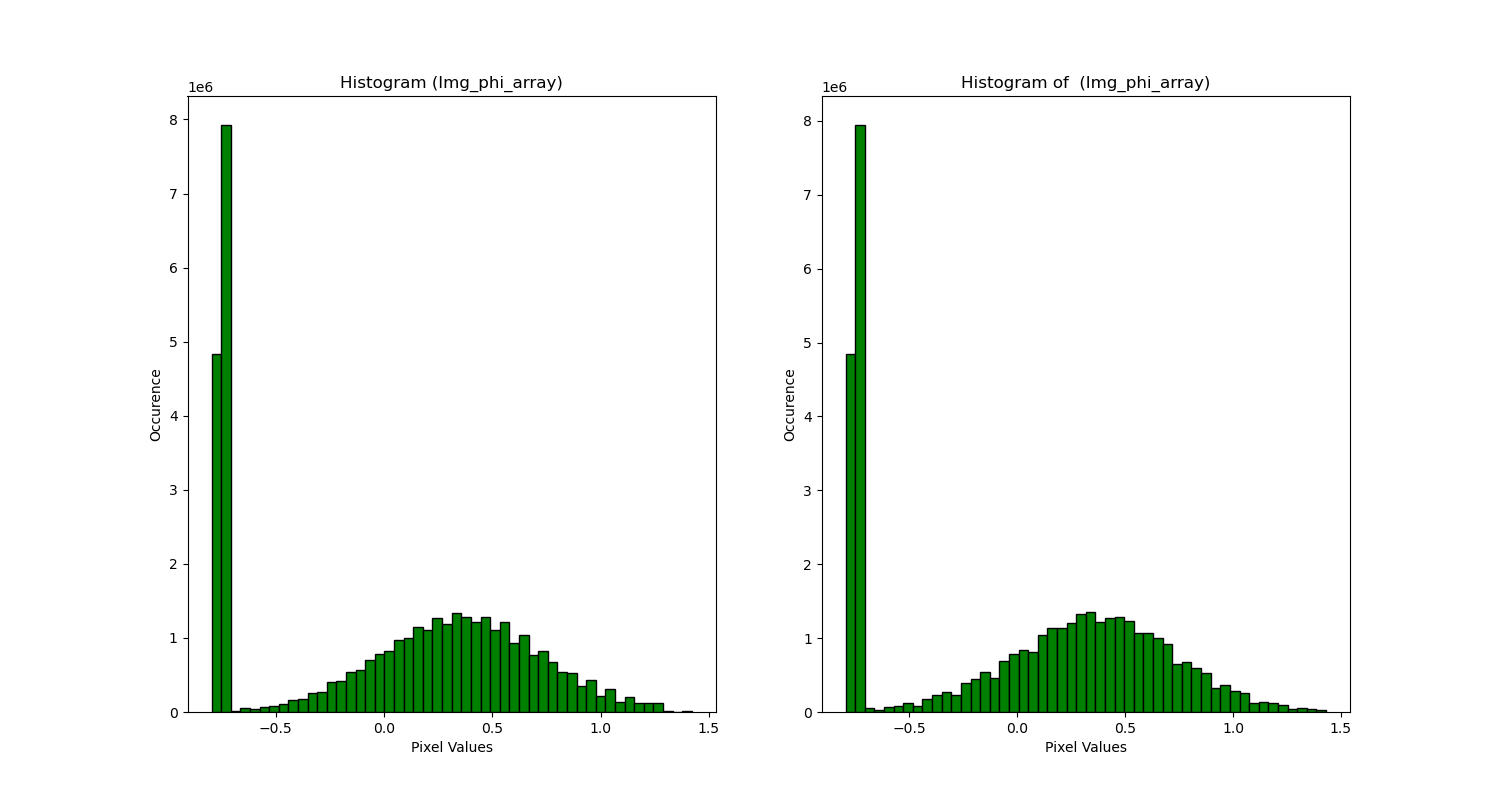

In [3]:

flattened_phi_array = Img_phi_array.flatten()
flattened_chi_array = Img_chi_array.flatten()
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

ax[0].hist(flattened_phi_array, bins=50, color='green', edgecolor='black')
ax[0].set_title('Histogram (Img_phi_array)')
ax[0].set_xlabel('Pixel Values')
ax[0].set_ylabel('Occurence')

ax[1].hist(flattened_chi_array, bins=50, color='green', edgecolor='black')
ax[1].set_title('Histogram of  (Img_chi_array)')
ax[1].set_xlabel('Pixel Values')
ax[1].set_ylabel('Occurence')
plt.show

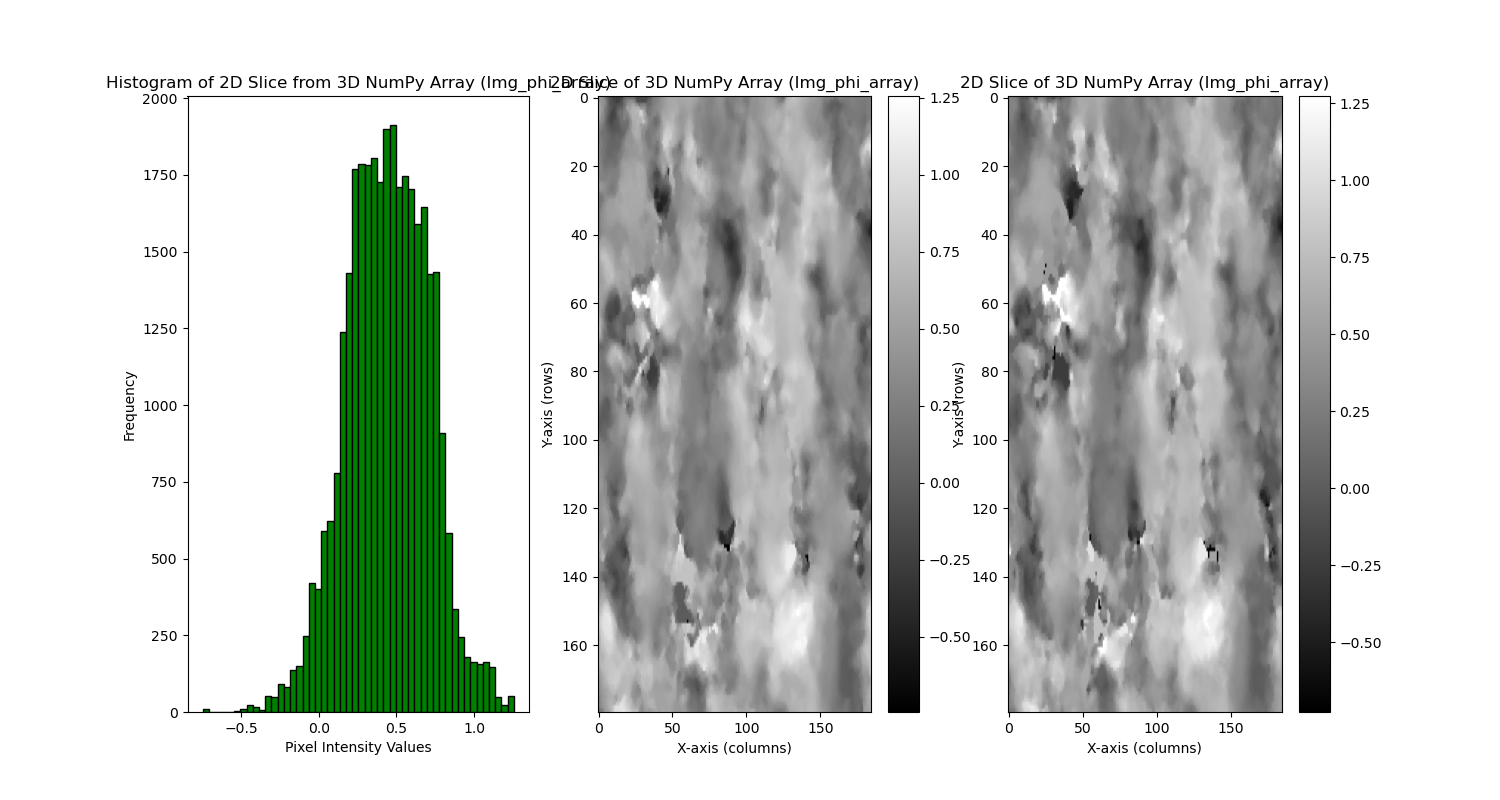

In [4]:
# Create a figure with two subplots
fig, ax = plt.subplots(1, 3, figsize=(15, 8))
#Choose a specific time Frame
k= 6
# Plot the histogram
ax[0].hist(Img_phi_array_cropped[k].flatten(), bins=50, color='green', edgecolor='black')
ax[0].set_title('Histogram of 2D Slice from 3D NumPy Array (Img_phi_array)')
ax[0].set_xlabel('Pixel Intensity Values')
ax[0].set_ylabel('Frequency')

# Plot the 2D slice as an image
phi_slice = Img_phi_array_cropped[k]
img = ax[1].imshow(phi_slice, cmap='gray', aspect='auto')
fig.colorbar(img, ax=ax[1])  # Add a colorbar to the image plot
ax[1].set_title('2D Slice of 3D NumPy Array (Img_phi_array)')
ax[1].set_xlabel('X-axis (columns)')
ax[1].set_ylabel('Y-axis (rows)')

# Plot the 2D slice as an image
phi_slice = Img_phi_array_cropped[k+1]
img = ax[2].imshow(phi_slice, cmap='gray', aspect='auto')
fig.colorbar(img, ax=ax[2])  # Add a colorbar to the image plot
ax[2].set_title('2D Slice of 3D NumPy Array (Img_phi_array)')
ax[2].set_xlabel('X-axis (columns)')
ax[2].set_ylabel('Y-axis (rows)')

plt.show()

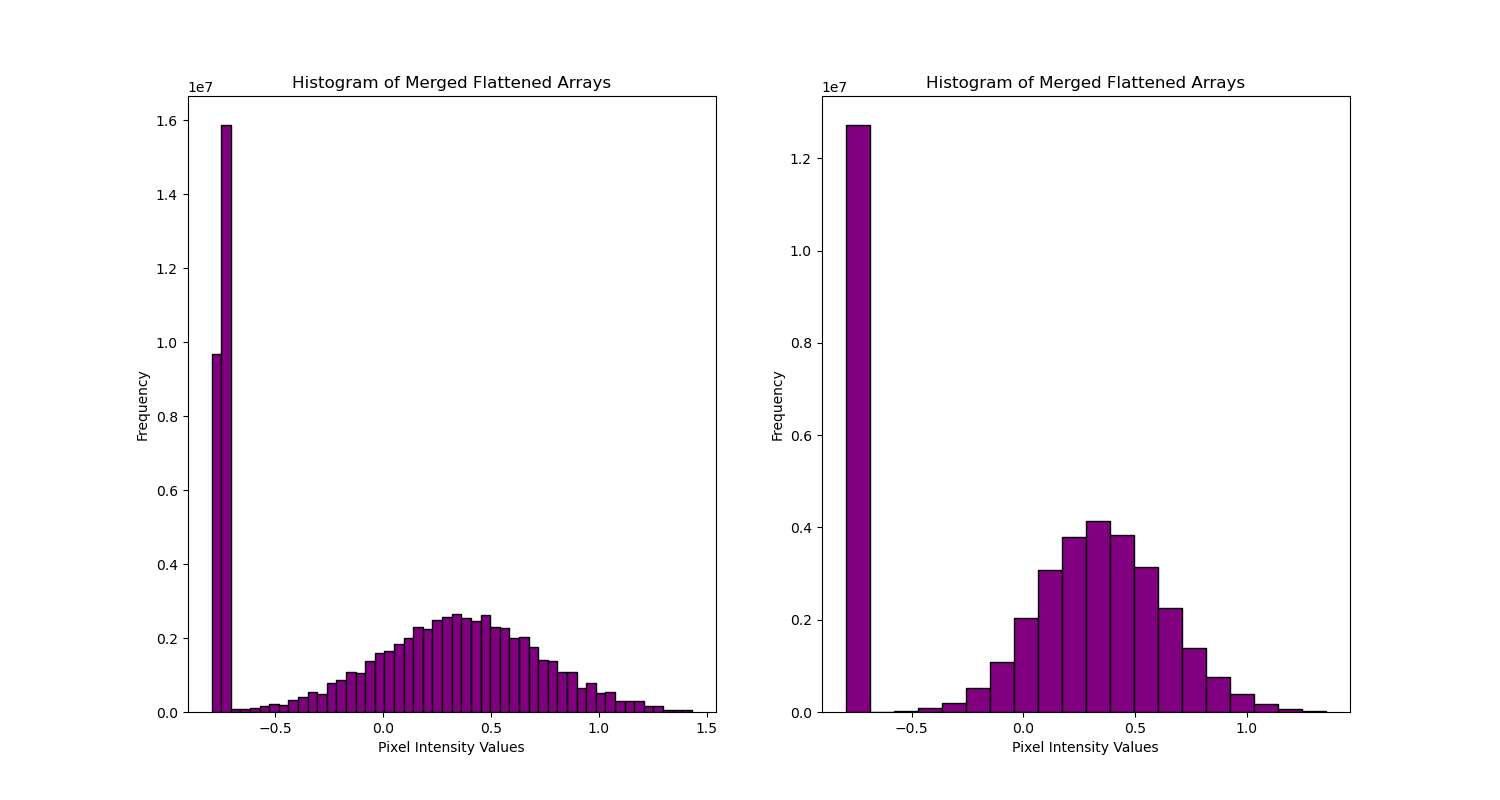

In [5]:
merged_array = np.concatenate((flattened_phi_array, flattened_chi_array))
img_chi_phi_average = (Img_chi_array + Img_phi_array) / 2
img_chi_phi_average_cropped = (Img_chi_array_cropped + Img_phi_array_cropped) / 2

fig,ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].hist(merged_array, bins=50, color='purple', edgecolor='black')
ax[0].set_title('Histogram of Merged Flattened Arrays')
ax[0].set_xlabel('Pixel Intensity Values')
ax[0].set_ylabel('Frequency')

ax[1].hist(img_chi_phi_average.flatten(), bins=20, color='purple', edgecolor='black')
ax[1].set_title('Histogram of Merged Flattened Arrays')
ax[1].set_xlabel('Pixel Intensity Values')
ax[1].set_ylabel('Frequency')
plt.show()

What if we take the average of the two maxima for the np arrays

(12, 180, 185)
(12, 180, 185)
(12, 180, 185)
(12, 180, 185)
(12, 180, 185)
(12, 180, 185)
(12, 180, 185)
(12, 180, 185)
(12, 180, 185)
(12, 180, 185)


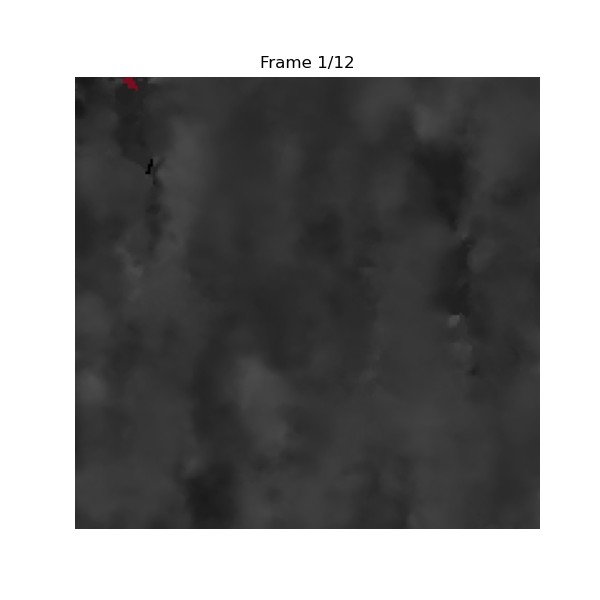

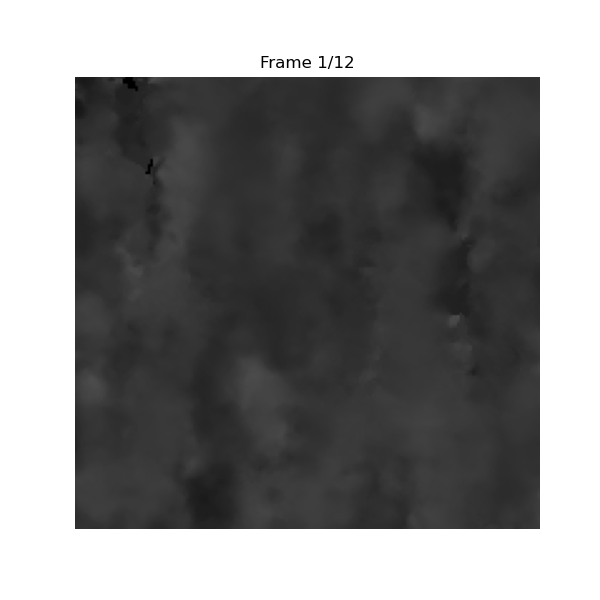

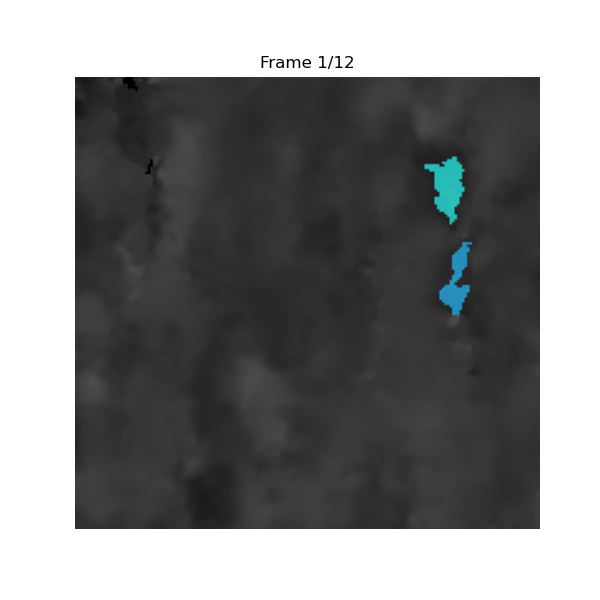

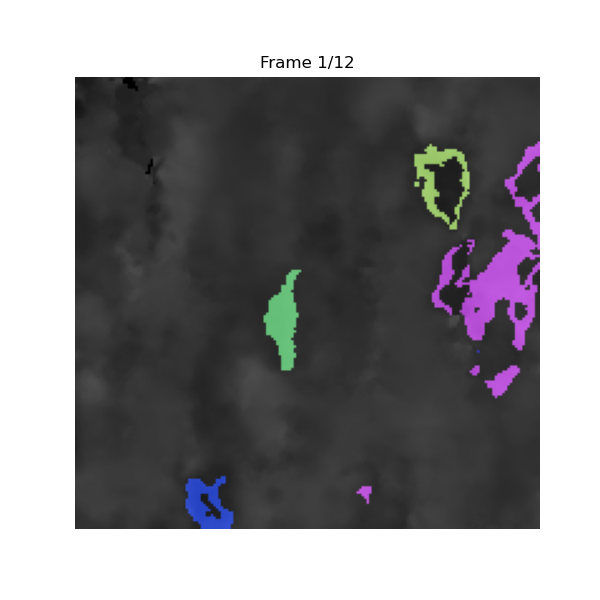

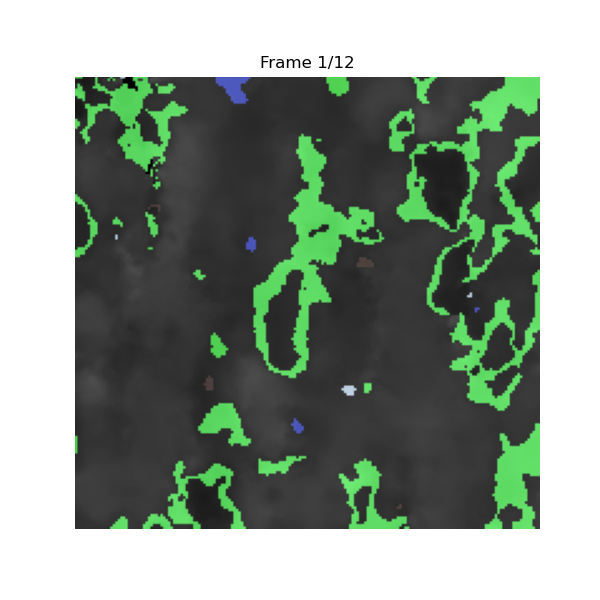

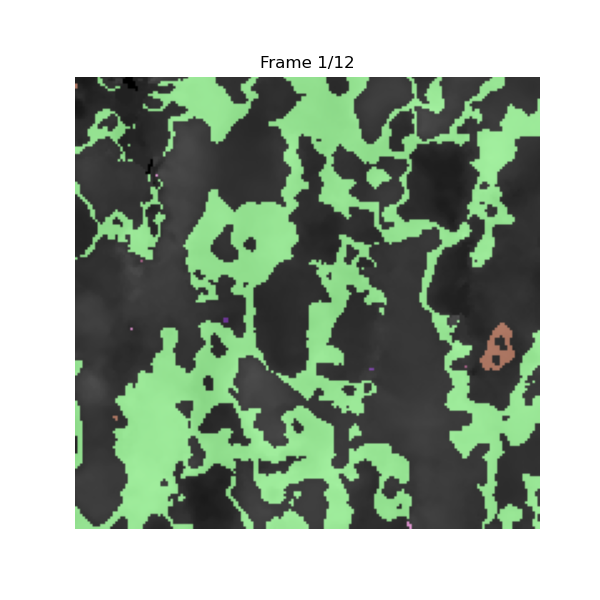

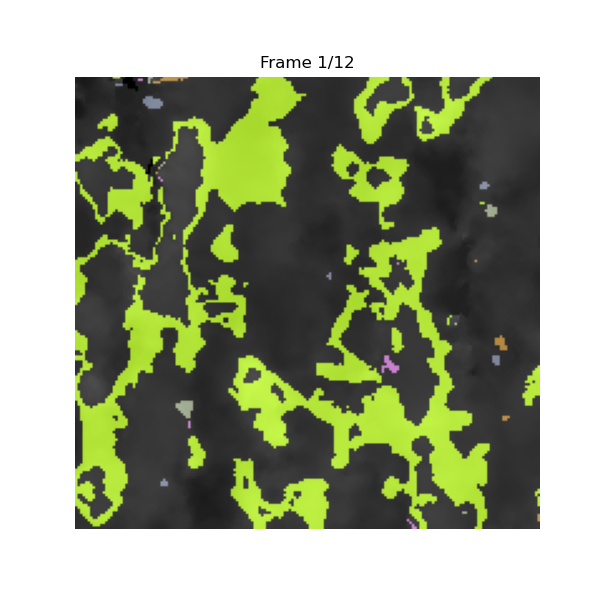

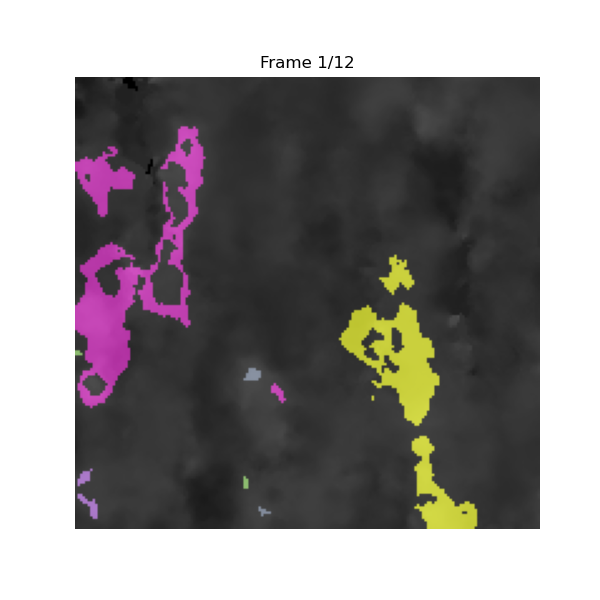

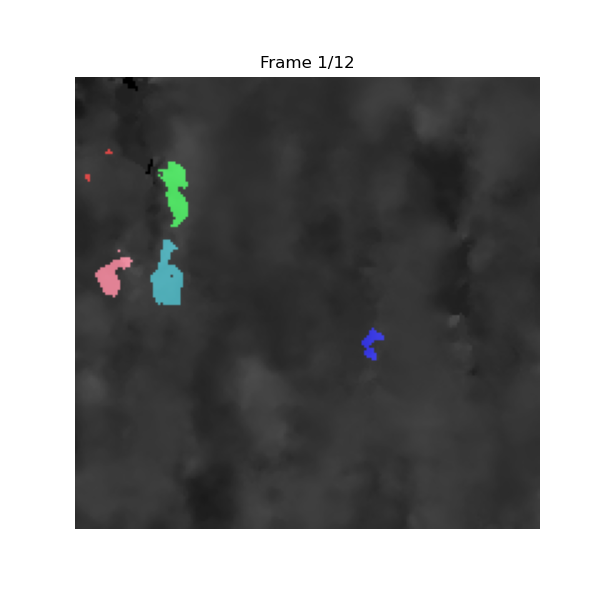

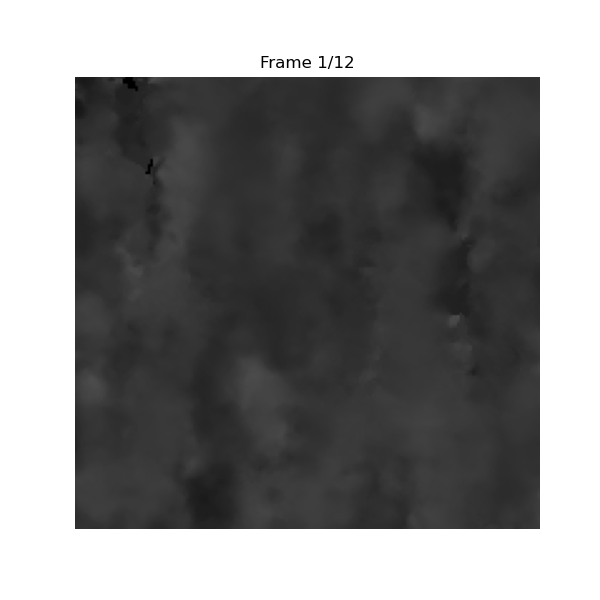

In [6]:

binary_masks, hist_bins = create_binary_masks(Img_chi_array_cropped, 10)

# Step 2: Perform connected component labeling
labeled_masks = connected_components_on_masks(binary_masks, connectivity=3)

# Step 3: Visualize the first binary mask's connected components in 3D
for i, (labeled_mask, num_features) in enumerate(labeled_masks):
    components_to_keep = 5
    labeled_processed_mask = postprocess_connected_components(labeled_mask,closing_size=10,num_components=components_to_keep)  # Visualize only the connected components
    visualize_3d(labeled_processed_mask, img_chi_phi_average_cropped,i,num_components=components_to_keep, save=False)  # Visualize only the connected components